# Draft: Point estimation by the example of quantiles

This notebook is an adaptation of the [tutorial notebook](https://github.com/bayesflow-org/bayesflow/blob/dev/examples/Linear_Regression.ipynb) on linear regression by Paul Bürkner and Lars Kühmichel.

We use the same simulator but do point estimation instead of learning the full posterior distribution.  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

np.set_printoptions(suppress=True)

# ensure the backend is set
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import keras

# for BayesFlow devs: this ensures that the latest dev version can be found
import sys
sys.path.append('../')

import bayesflow as bf

## Simulator for linear regression

In [3]:
def meta(batch_size):
    # batch_size needs to be present but will be ignored here
    # N: number of observation in a dataset
    N = np.random.randint(5, 15)
    return dict(N=N)

def prior():
    # beta: regression coefficients (intercept, slope)
    beta = np.random.normal([2, 0], [3, 1])
    # sigma: residual standard deviation
    sigma = np.random.gamma(1, 1)
    return dict(beta=beta, sigma=sigma)

def likelihood(beta, sigma, N):
    # x: predictor variable
    x = np.random.normal(0, 1, size=N)
    # y: response variable
    y = np.random.normal(beta[0] + beta[1] * x, sigma, size=N)
    return dict(y=y, x=x)

In [4]:
simulator = bf.simulators.make_simulator([prior, likelihood], meta_fn=meta)

In [5]:
# Generate a batch of three training samples
sample_data = simulator.sample(50)
print(sample_data["N"])
print(sample_data["beta"].shape)
print(sample_data["sigma"].shape)
print(sample_data["x"].shape)
print(sample_data["y"].shape)

5
(50, 2)
(50, 1)
(50, 5)
(50, 5)


In [6]:
adapter = (
    bf.Adapter()
    .broadcast("N", to="x")
    .as_set(["x", "y"])
    .constrain("sigma", lower=0)
    .standardize(exclude=["N"])
    .apply(include="N", forward=lambda n: np.sqrt(n), inverse=lambda n: n**2)
    .concatenate(["beta", "sigma"], into="inference_variables")
    .concatenate(["x", "y"], into="summary_variables")
    .rename("N", "inference_conditions")
)

## Defining an optimization problem with a quantile scoring rule

In [7]:
inference_network = bf.networks.QuantileRegressor(quantile_levels=[0.1, 0.5, 0.9])
summary_network = bf.networks.DeepSet(depth=2)

In [8]:
approximator = bf.ContinuousPointApproximator(
   inference_network=inference_network,
   summary_network=summary_network,
   adapter=adapter,
)

In [9]:
epochs = 10
num_batches = 128
batch_size = 64
learning_rate = keras.optimizers.schedules.CosineDecay(5e-4, decay_steps=epochs*num_batches, alpha=1e-6)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
approximator.compile(optimizer=optimizer)

## Training

In [10]:
history = approximator.fit(
    epochs=epochs,
    num_batches=num_batches,
    batch_size=batch_size,
    simulator=simulator,
)

INFO:bayesflow:Building dataset from simulator instance of SequentialSimulator.
INFO:bayesflow:Using 12 data loading workers.
INFO:bayesflow:Building on a test batch.


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - loss: 0.1782 - loss/inference_loss: 0.1782 
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1141 - loss/inference_loss: 0.1141
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1013 - loss/inference_loss: 0.1013 
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0931 - loss/inference_loss: 0.0931 
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0903 - loss/inference_loss: 0.0903
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0881 - loss/inference_loss: 0.0881
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0857 - loss/inference_loss: 0.0857
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0854 - loss/inference_loss: 0.0854 
Epoch 9/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0816 - loss/inference_loss: 0.0816
Epoch 10/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0813 - loss/inference_loss: 0.0813


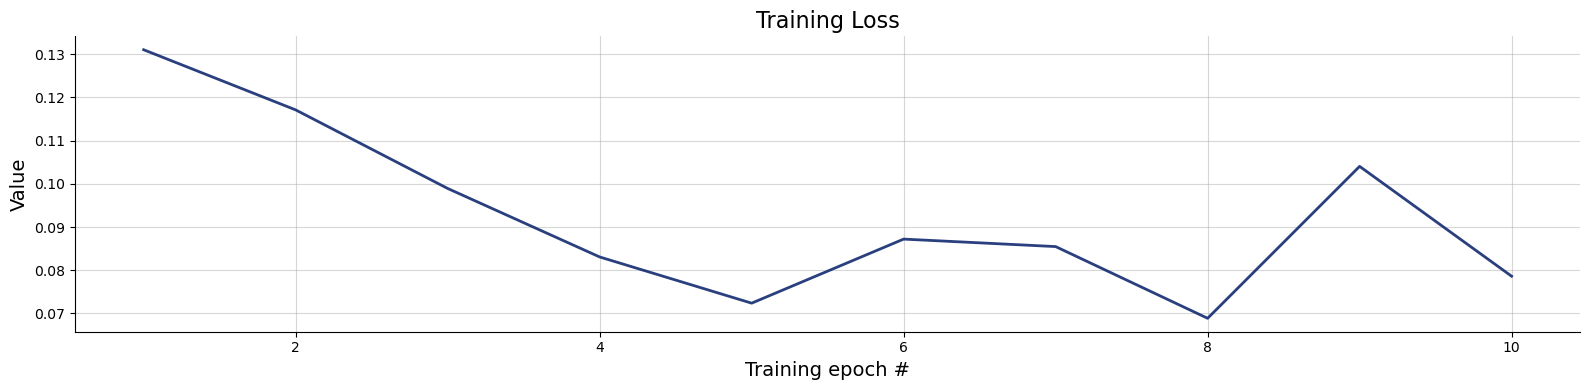

In [11]:
# Visualize losses
f = bf.diagnostics.plots.loss(
    train_losses=np.array(history.history["loss"]).astype(np.float32)
)

## Preliminary plotting of recovery

In [12]:
pred_quantiles = approximator.estimate(conditions={k:v for k,v in sample_data.items() if k in ["N", "x", "y"]})

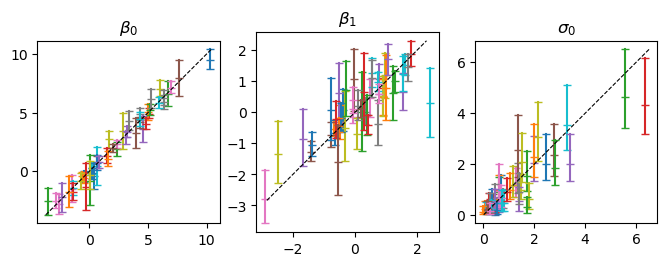

In [13]:
# basic plots just to take a look at recovery
inference_variables = [("beta", 0), ("beta",1), ("sigma",0)]
fig, axes = plt.subplots(1,len(inference_variables), figsize=(8,5))

for i,ax in enumerate(axes):
    ax.set_aspect('equal')
    
    inference_variable, var_idx = inference_variables[i]
    
    for j in range(sample_data[inference_variable].shape[0]):
        num_quantiles = pred_quantiles[inference_variable].shape[1]
        x = [sample_data[inference_variable][j,var_idx]]*num_quantiles
        y = pred_quantiles[inference_variable][j,:,var_idx]
        ax.plot(x, y, marker="_")
    
    low_corner, high_corner = np.min(pred_quantiles[inference_variable][:,var_idx]), np.max(pred_quantiles[inference_variable][:,:,var_idx])
    ax.plot([low_corner, high_corner], [low_corner, high_corner], color="black", linewidth=0.8, linestyle="--")
    title = f"$\{inference_variable}_{var_idx}$" 
    ax.set_title(title)

Above the horizontal bars of the same color correspond to the 0.1, 0.5 and 0.9 quantiles respectively.